# Hands-on 02: Caracterização do desvanecimento de pequena escala


## Parte 01:Separação dos desvanecimentos de Larga e Pequena escalas


### Objetivos
As metas desse tutorial são ajudar o usuário a:
- Gerar uma série temporal sintética com Perda de Percurso, Sombreamento e Desvanecimento m-Nakagami
- Estimar cada desvanecimento por meio de regressão linear e filtragem
- Fazer gráficos e comparar as partes geradas sinteticamente e as partes estimadas 


## Prática 01: Criação do sinal sintético

Vamos escrever um código para criação de um sinal sintético com Perda de Percurso (modelo decaimento logaritmo), Sombreamento Log-Normal e Desvanecimento m-Nakagami. O código deve ser parametrizável e as séries temporais devem ser salvas em arquivo. Gráficos devem ilustrar o comportamento de cada parte do sinal sintético.


**Passo 01:** Crie um script chamado **handson3_P1_1.m** com o código a seguir. Nesse código, vamos:

1. Criar a estrutura **sPar** de entrada de parâmetros;
2. Gerar um canal com desvanecimento de larga e pequena escalas;
3. A perda de percurso segue o modelo de log-linear com coeficiente de perda de percurso especificado por **sPar.n**.  geração da perda de percurso deve seguir as seguintes especificações:
 - O modelo da perda de percurso é $PL = P_0 + 10\cdot n\cdot log10(d/d_0)$, sendo $P_0$ a potência medida na distância de referência $d_0$, especificadas por **sPar.P0** e **sPar.d0**, respectivamente; 
 - A distância final da rota de medição é especificada por **sPar.totalLength** em metros;
 - O número de pontos de medição é especificado por **sPar.nPoints**;
4. O sombreamento $Xs$ segue um modelo log-normal com média zero e desvio padrão especificado por **sPar.sigma**. A geração do sombreamento deve seguir as seguintes especificações:
 - Amostras de sombreamento independentes devem sorteadas para pontos de medição em uma janela de **sPar.shadowingWindow**  amostras (isso quer dizer que depois de **sPar.shadowingWindow**  amostras, o sombreamento é descorrelacionado);
 - Amostras dentro de uma janela especificada por **sPar.shadowingWindow** devem ser iguais com intuito de modelar o sombreamento correlacionado; 
 - Para evitar variações brutas entre amostras independentes do sombreamento, um filtro média móvel com janela igual a **sPar.shadowingWindow** deve ser aplicado ao vetor de amostras de sombreamento;
 - Ajustes na média e no desvio padrão devem ser feitos para garantir seus valores amostrais;
5. O desvanecimento de pequena escala $Xf$ segue um modelo m-Nakagami com o valor de $m$ especificado por **sPar.m**. A geração do desvanecimento de pequena escala deve seguir as seguintes especificações:
 - A PDF da envoltória do sinal é m-Nakagami normalizada igual a $f(x; m) = \frac{2\cdot m^m}{\Gamma(m)}\cdot x^{2\cdot m-1} \cdot e^{-m\cdot x^2} $ [[fonte]](https://pdfs.semanticscholar.org/3e81/7c531d90f63a3c43fe7076189e942d6fed01.pdf);
5. Calcular a potência recebida como: $Prx = Ptx - PL + Xs + Xf$, todos em dB.

Canal sintético:
   Média do sombreamento: -0.77808
   Std do sombreamento: 5.8146
   Janela de correlação do sombreamento: 200 amostras
   Expoente de path loss: 4
   m de Nakagami: 4


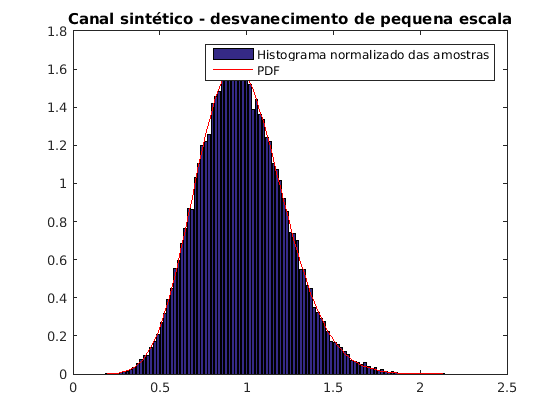

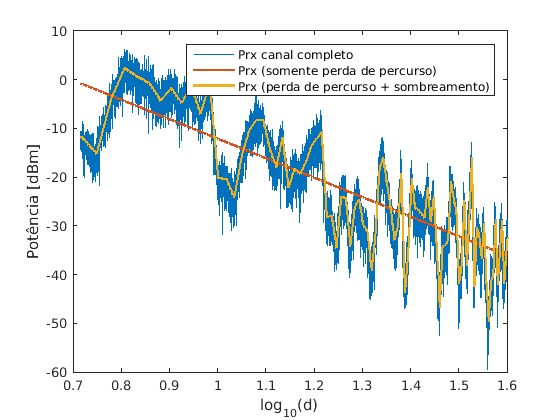

In [2]:
close all;clear all;clc;
% Parâmetros para geração do canal sintético
sPar.d0 = 5;                     % distância de referência d0
sPar.P0 = 0;                     % Potência medida na distância de referência d0
sPar.nPoints = 50000;            % Número de amostras da rota de medição
sPar.totalLength = 100;          % Distância final da rota de medição
sPar.n = 4;                      % Expoente de perda de percurso
sPar.sigma = 6;                  % Desvio padrão do shadowing em dB
sPar.shadowingWindow = 200;      % Tamanho da janela de correlação do shadowing (colocar em função da distância de correlação)
sPar.m = 4;                      % Parâmetro de Nakagami
sPar.txPower = 0;                % Potência de transmissão em dBm
sPar.nCDF = 40;                  % Número de pontos da CDF normalizada
sPar.fileName  = 'Prx_sintetico';
% Distância entre pontos de medição
sPar.dMed = sPar.totalLength/sPar.nPoints;
% Vetor de distâncias do transmissor (além da distância de referência)
vtDist = sPar.d0:sPar.dMed:sPar.totalLength;
% Número de amostras geradas
nSamples = length(vtDist);
% Geração da Perda de percurso (determinística)
vtPathLoss = sPar.P0 + 10*sPar.n*log10(vtDist./sPar.d0);
% Geração do Sombreamento (V.A. Gaussiana com média zero e desvio padrão sigma)
nShadowSamples = floor(nSamples/sPar.shadowingWindow);
vtShadowing = sPar.sigma*randn(1,nShadowSamples);
% Amostras para a última janela
restShadowing = sPar.sigma*randn(1,1)*ones(1,mod(nSamples,sPar.shadowingWindow));
% Repetição do mesmo valor de sombreamento durante a janela de correlação
vtShadowing = ones(sPar.shadowingWindow,1)*vtShadowing;
% Amostras organizadas em um vetor
vtShadowing = [reshape(vtShadowing,1,nShadowSamples*sPar.shadowingWindow),restShadowing];
% Filtragem para evitar variação abrupta do sombreamento (filtro média móvel)
% O sombreamento tem menos "2*jan" amostras devido a filtragem
jan = sPar.shadowingWindow/2;
iCont = 1;
for i = jan+1:nSamples-jan,
    vtShadCorr(iCont) = mean(vtShadowing(i-jan:i+jan));
    iCont = iCont+1;
end
% Ajuste do desvio padrão depois do filtro de correlação do sombreamento
vtShadCorr = vtShadCorr*std(vtShadowing)/std(vtShadCorr);
vtShadCorr = vtShadCorr - mean(vtShadCorr)+ mean(vtShadowing);
%
% Geração do desvanecimento de pequena escala: Nakagami fading
% PDF da envolvtória normalizada
fpNakaPdf = @(x)((2.*sPar.m.^sPar.m)./(gamma(sPar.m))).*x.^(2.*sPar.m-1).*exp(-(sPar.m.*x.^2));
% Gerador de números aleatórios com distribuição Nakagami
vtNakagamiNormEnvelope = slicesample(1,nSamples,'pdf',fpNakaPdf);
% Fading em dB (Potência)
vtNakagamiSampdB = 20.*log10(vtNakagamiNormEnvelope');
%
% Cálculo da Potência recebida
vtTxPower = sPar.txPower*ones(1,nSamples);
% Ajuste do número de amostras devido ao filtragem
vtTxPower = vtTxPower(jan+1:nSamples-jan);
vtPathLoss = vtPathLoss(jan+1:nSamples-jan);
vtFading = vtNakagamiSampdB(jan+1:nSamples-jan);
vtDist = vtDist(jan+1:nSamples-jan);
% Potência recebida
vtPrx = vtTxPower-vtPathLoss+vtShadCorr+vtFading;
%
% Salvamento dos dados
%    Para excel:
dlmwrite([sPar.fileName '.txt'], [vtDist',vtPrx'], 'delimiter', '\t');
%    Matlab
save([sPar.fileName '.mat'],'vtDist', 'vtPathLoss', 'vtShadCorr', 'vtFading', 'vtPrx');
%
% Mostra informações do canal sintético
disp('Canal sintético:')
disp(['   Média do sombreamento: ' num2str(mean(vtShadCorr)) ]);
disp(['   Std do sombreamento: ' num2str(std(vtShadCorr)) ]);
disp(['   Janela de correlação do sombreamento: ' num2str(sPar.shadowingWindow) ' amostras' ]);
disp(['   Expoente de path loss: ' num2str(sPar.n) ]);
disp(['   m de Nakagami: ' num2str(sPar.m) ]);
%
% Plot do desvanecimento de larga escala (gráfico linear)
figure;
% Log da distância
log_distancia = log10(vtDist);
% Potência recebida com canal completo
plot(log_distancia,vtPrx); hold all;
% Potência recebida com path loss
plot(log_distancia,sPar.txPower-vtPathLoss,'linewidth', 2)
% Potência recebida com path loss e shadowing
plot(log_distancia,sPar.txPower-vtPathLoss+vtShadCorr,'linewidth', 2)
%title('Canal sintético: Potência recebida no receptor vs. log da distância')
xlabel('log_{10}(d)');
ylabel('Potência [dBm]');
legend('Prx canal completo', 'Prx (somente perda de percurso)', 'Prx (perda de percurso + sombreamento)');
xlim([0.7 1.6])
%
% Plot da geração do desvanecimento Nakagami
figure;
[f,x] = hist(vtNakagamiNormEnvelope,100);
bar(x,f/trapz(x,f)); % Histograma normalizado = PDF (das amostras)
hold all;
plot(x,fpNakaPdf(x),'r'); % PDF da distribuição
title('Canal sintético - desvanecimento de pequena escala');
legend('Histograma normalizado das amostras','PDF');

**A execução do código resulta em:**
1. Mensagem de texto com informações sobre o canal sintético gerado;
2. Os seguinte vetores:
 - vtDist: Pontos de medição [m];
 - vtPathLoss: Amostras da perda de percurso; 
 - vtShadCorr: Amostras do somrbeamento;
 - vtFading: Amostras do desvanecimento de pequena escala;
 - vtPrx: Potência recebida com o canal completo.
3. Um arquivo .mat com nome especificado no parâmetro **sPar.fileName**;
4. Um gráfico mostrando a potência recebida com desvanecimento de larga e pequena escalas;
5. Gráfico com histograma e PDF m-Nakagami do desvanecimento de pequena escala.
 
** Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**

## Prática 02: Estimação do parâmetros do canal

Vamos escrever um código para, de posse do sinal medido, estimarmos a Perda de Percurso (modelo decaimento logaritmo), o Sombreamento Log-Normal (seu desvio padrão) e Desvanecimento de pequena escala (sua distribuição e parâmetros). O código deve ser parametrizável e gráficos devem ilustrar o comportamento de cada parte do sinal original e estimado.

**Passo 01:** Crie uma função chamada **fGeraCanal.m** com o código a seguir. Ele é uma versão do código **handson3_P1_1.m** escrito em forma de função. Isso foi feito para melhor organizar o código da prática 02.

In [5]:
%%file fGeraCanal.m
function [vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrx] = fGeraCanal(sParams)
% Propósito: Gerar canal composta de path loss, shadowing e desvanecimento plano
%
% ENTRADAS: na estrutura sParams
%    - nPoints: Número de amostras
%    - totalLength: distância máxima da rota
%    - P0: potência de referência medida na distância d0
%    - d0: distância d0 de referência
%    - n: expoente de perda de percurso
%    - sigma: desvio padrão do sombreamento lognormal [dB]
%    - Tamanho da janela de correlação do sombreamento [amostras]
%    - m: parâmetro de Nakagami
%    - dMed: distância entre pontos de medição (totalLength/nPoints)
%    - txPower: potência de transmissão em dBm
%
% SAÍDAS:
%    - dPath: pontos de medição [m]
%    - pathLoss: amostras da perda de percurso
%    - shd: amostras do somrbeamento
%    - fading: amostras do desvanecimento de pequena escala
%    - Prx: potência recebida com o canal completo
%
% Parser dos parâmetros de entrada
nPoints = sParams.nPoints;
totalLength = sParams.totalLength;
P0 = sParams.P0;
d0 = sParams.d0;
n = sParams.n;
sigma = sParams.sigma;
shadowingWindow = sParams.shadowingWindow;
m = sParams.m;
dMed = sParams.dMed;
txPower = sParams.txPower;
%
% Distância do transmissor (além da distância de referência)
d = d0:dMed:totalLength;
nSamples = length(d);
%
% Geração da Perda de percurso (determinística)
vtPathLoss = P0 + 10*n*log10(d./d0);
%
% Geração do Sombreamento
nShadowSamples = floor(nSamples/shadowingWindow);
shadowing = sigma*randn(1,nShadowSamples);
% Amostras para a última janela
restShadowing = sigma*randn(1,1)*ones(1,mod(nSamples,shadowingWindow));
% Repetição do mesmo valor de sombreamento durante a janela de correlação
shadowing = ones(shadowingWindow,1)*shadowing;
% Amostras organizadas em um vetor
shadowing = [reshape(shadowing,1,nShadowSamples*shadowingWindow),restShadowing];
% Filtragem para evitar variação abrupta do sombreamento
jan = shadowingWindow/2;
iCont = 1;
for i = jan+1:nSamples-jan,
    vtShadCorr(iCont) = mean(shadowing(i-jan:i+jan)); %diminuir a variação brusca do sombreamento
    iCont = iCont+1;
end
% Ajuste do desvio padrão depois do filtro de correlação do sombreamento
vtShadCorr = vtShadCorr*std(shadowing)/std(vtShadCorr);
vtShadCorr = vtShadCorr - mean(vtShadCorr)+ mean(shadowing);
%
% Geração do desvanecimento de pequena escala
% Nakagami fading
nakagamiPdf = @(x)((2.*m.^m)./(gamma(m))).*x.^(2.*m-1).*exp(-(m.*x.^2));
nakagamiNormEnvelope = slicesample(1,nSamples,'pdf',nakagamiPdf);
nakagamiSamp=20.*log10(nakagamiNormEnvelope');
%
% Cálculo da Potência recebida
txPower = txPower*ones(1,nSamples);
% Ajuste do número de amostras devido a filtragem
txPower = txPower(jan+1:nSamples-jan);
vtPathLoss = vtPathLoss(jan+1:nSamples-jan);
vtFading = nakagamiSamp(jan+1:nSamples-jan);
vtDist = d(jan+1:nSamples-jan);
% Potência recebida
vtPrx = txPower-vtPathLoss+vtShadCorr+vtFading;

Created file '/home/gppcom/2019/EEC1714/fGeraCanal.m'.


**Passo 02:** Crie um script chamado **handson3_P2_1.m** com o código a seguir. Nesse código, vamos:

1. Separar o desvanecimento de larga e pequena escalas. Para isso, faça:
 - De posse da série temporal que representa a potência recebida **vtPrx**, passe um filtro média móvel com janela especificada no parâmetro **sPar.dW**;
 - A saída do filtro será o desvanecimento de larga escala estimado **vtDesLarga**. Ele é a perda de percurso somanda com o sombreamento;
 - Para cálcular a série temporal que representa o desvanecimento de pequena escala, é só subtrair o desvanecimento de larga escala estimado da potência recebida **vtPrx** - **vtDesLarga**; 
2. Usar interpolação linear em **vtPrx** para estimar a perda de percurso **vtPathLossEst**;
3. Informar o expooente de perda de percurso estimado;
4. Fazer um gráfico da perda de percurso original e estimada (comparação visual);
5. De posse da perda de percurso e do desvanecimento de larga escala, calcular a série temporal que representa o sombreamento: **vtDesLarga** - **vtPathLossEst**;
6. Fazer gráficos comparando cada série estimada com seu par original;
7. Estimar a CDF normalizada do desvanecimento de pequena escala e comparar com a formulação teórica do m-Nakagami para alguns valores de $m$.

Estimação dos parâmetros de larga escala (W = 100):
   Expoente de perda de percurso estimado n = 4.0028
   Desvio padrão do sombreamento estimado = 5.6611
   Média do sombreamento estimado = 0.77029


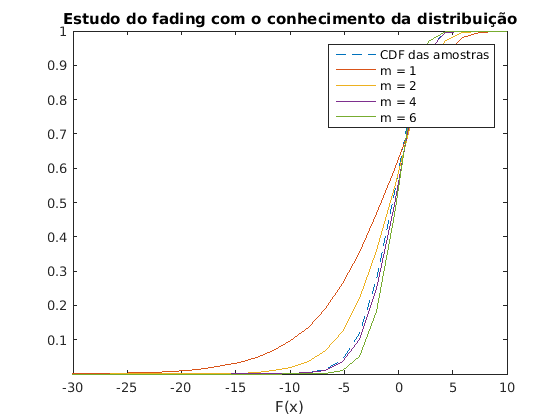

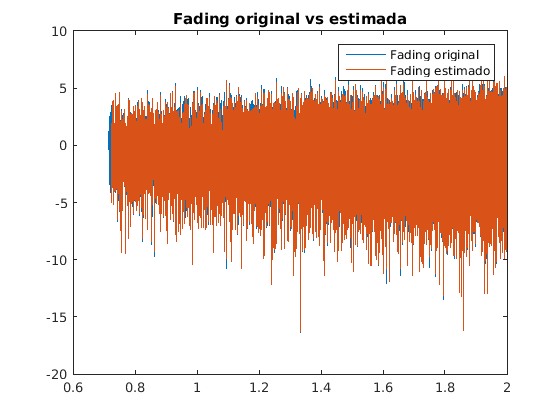

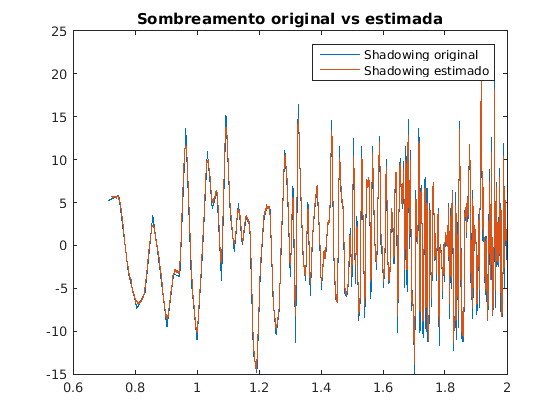

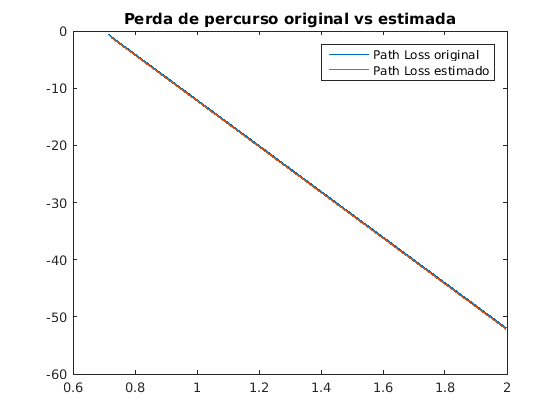

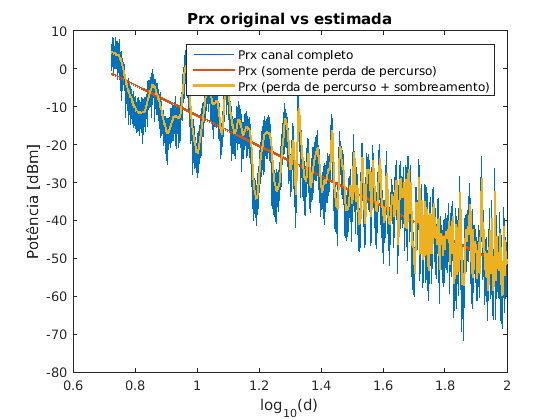

In [7]:
close all;clear all;clc;
% Parâmetros para geração do canal sintético
sPar.d0 = 5;                     % distância de referência d0
sPar.P0 = 0;                     % Potência medida na distância de referência d0 (em dBm)
sPar.nPoints = 50000;            % Número de amostras da rota de medição
sPar.totalLength = 100;          % Distância final da rota de medição
sPar.n = 4;                      % Expoente de perda de percurso
sPar.sigma = 6;                  % Desvio padrão do shadowing em dB
sPar.shadowingWindow = 200;      % Tamanho da janela de correlação do shadowing (colocar em função da distância de correlação)
sPar.m = 4;                      % Parâmetro de Nakagami
sPar.txPower = 0;                % Potência de transmissão em dBm
sPar.nCDF = 40;                  % Número de pontos da CDF normalizada
sPar.dW = 100;                   % Janela de estimação do sombreamento
% Distância entre pontos de medição
sPar.dMed = sPar.totalLength/sPar.nPoints;
% Chama função que gera o cabal sintético
[vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrxdBm] = fGeraCanal(sPar);
% Transforma potência em mWatts
vtPtrxmW = 10.^(vtPrxdBm/10);
nSamples = length(vtPtrxmW);
% Vetores para canal estimado
vtDesLarga = [];
vtDesPequeEst = [];
%
% Cálculo do desvanecimenro lento e rápido
dMeiaJanela = round((sPar.dW-1)/2);  % Meia janela
ij = 1;
for ik = dMeiaJanela + 1 : nSamples - dMeiaJanela
    % Desvanecimento de larga escala: perda de percurso + sombreamento [dB]
    vtDesLarga(ij) = 10*log10(mean(vtPtrxmW(ik-dMeiaJanela:ik+dMeiaJanela)));
    % Desvanecimento de pequena escala [dB]
    vtDesPequeEst(ij) = vtPrxdBm(ik)-vtDesLarga(ij);
    ij = ij + 1;
end
%
% Cálculo da envoltória normalizada (para efeitos de cálculo do fading)
indexes = dMeiaJanela+1 : nSamples-dMeiaJanela;
vtPrxW = ((10.^(vtPrxdBm(indexes)./10))/1000);
desLarga_Lin = (10.^(vtDesLarga(1:length(indexes))./10))/1000;
envNormal = sqrt(vtPrxW)./sqrt(desLarga_Lin);
%
% Ajuste no tamanho dos vetores devido a filtragem
vtDistEst = vtDist( dMeiaJanela+1 : nSamples-dMeiaJanela );
vtPrxdBm = vtPrxdBm( dMeiaJanela+1 : nSamples-dMeiaJanela );
%
% Cálculo reta de perda de percurso
vtDistLog = log10(vtDist);
vtDistLogEst = log10(vtDistEst);
% Cálculo do coeficientes da reta que melhor se caracteriza a perda de percurso
dCoefReta = polyfit(vtDistLogEst,vtPrxdBm,1); 
% Expoente de perda de percurso estimado
dNEst = -dCoefReta(1)/10;
disp(['Estimação dos parâmetros de larga escala (W = ' num2str(sPar.dW) '):'])
disp(['   Expoente de perda de percurso estimado n = ' num2str(dNEst)]);
% Perda de percurso estimada para os pontos de medição
vtPathLossEst = polyval(dCoefReta,vtDistLogEst);  
%
% Sombreamento
vtShadCorrEst = vtDesLarga - vtPathLossEst;
% Calcula a variância do sombreamento estimado
stdShad = std(vtShadCorrEst);
meanShad = mean(vtShadCorrEst);
disp(['   Desvio padrão do sombreamento estimado = ' num2str(stdShad)]);
disp(['   Média do sombreamento estimado = ' num2str(meanShad)]);
vtPathLossEst = - vtPathLossEst;
vtPrxEst = sPar.txPower - vtPathLossEst + vtShadCorrEst + vtDesPequeEst;
%
% Estimação da CDF do desvanecimento de pequena escala
% Cálculo dos pontos do eixo x da cdf (espacamento igual entre os pontos)
vtn = 1 : sPar.nCDF;
xCDF = 1.2.^(vtn-1) * 0.01;
%
% Cálculo da CDF
den = 0;
cdffn=zeros(1,sPar.nCDF);
for ik = 1:sPar.nCDF
    for ij = 1:length(envNormal)
        if envNormal(ij) <= xCDF(ik)
            den = den + 1;
        end
        cdffn(ik) = cdffn(ik) + den;
        den = 0;
    end
end
%
% Monta estrutura do histograma
xccdfEst = 20.*log10(xCDF);
yccdfEst = cdffn/(cdffn(end)); 
% Figuras do canal estimado
figure;
% Potência recebida com canal completo
plot(vtDistLogEst,vtPrxEst); hold all;
% Potência recebida com path loss
plot(vtDistLogEst,sPar.txPower-vtPathLossEst,'linewidth', 2)
% Potência recebida com path loss e shadowing
plot(vtDistLogEst,sPar.txPower-vtPathLossEst+vtShadCorrEst,'linewidth', 2)
%title('Canal estimado: Potência recebida no receptor vs. log da distância')
xlabel('log_{10}(d)');
ylabel('Potência [dBm]');
legend('Prx canal completo', 'Prx (somente perda de percurso)', 'Prx (perda de percurso + sombreamento)');
title('Prx original vs estimada');
%
% Figura do Path loss (original vs estimado) 
figure;
plot(vtDistLog,-vtPathLoss);hold on;plot(vtDistLogEst,-vtPathLossEst);
legend('Path Loss original','Path Loss estimado');
title('Perda de percurso original vs estimada');
%
% Figura do Sombreamento (original vs estimado) 
figure;
plot(vtDistLog,vtShadCorr);hold on;plot(vtDistLogEst,vtShadCorrEst);
legend('Shadowing original','Shadowing estimado');
title('Sombreamento original vs estimada');
%
% Figura do Fading (original vs estimado) 
figure;
plot(vtDistLog,vtFading);hold on;plot(vtDistLogEst,vtDesPequeEst);
legend('Fading original','Fading estimado');
title('Fading original vs estimada');
%
% Plot das CDFs normalizadas Nakagami (assumindo que sabemos que o canal é m-Nakagami)- para vários valores de m
figure;
plot( xccdfEst, yccdfEst, '--' );
legendaNaka = [{'CDF das amostras'}];
hold all;
vtm = [1 2 4 6];
xCDF = 10.^(xccdfEst/20);
tam_dist = length(gammainc(1*xCDF.^2,1)); % Tamanho da distribuição
for ik = 1:length(vtm)%
    im = vtm(ik);
    cdfnaka(ik,1:tam_dist) = gammainc(im*xCDF.^2,im);
    semilogy(20.*log10(xCDF),cdfnaka(ik,:));
    legendaNaka = [legendaNaka ; {['m = ' num2str(vtm(ik))]}];
end
legend(legendaNaka);
axis([-30 10 1e-5 1]);
title('Estudo do fading com o conhecimento da distribuição');
xlabel('x');
xlabel('F(x)');

## Prática 03: Estimação da distribuição do fading e influência da janela de filtragem para separação dos desvanecimentos de larga e pequena escalas 

Vamos escrever um código para estimar o desvanecimento de pequena escala (sua distribuição e parâmetros) e investigar a influência do tamanho da janela de filtragem para separação dos desvanecimentos de larga e pequena escalas. O código irá aplicar alguns testes estatísticos e fará um estudo com o conhecimento a priori do canal e sem seu conhecimento.

**Passo 01:** Crie uma função chamada **fGeraCanal.m** da prática 02.


**Passo 02:** Crie uma função chamada **fEstimaCanal.m** com o código a seguir. Ele é uma versão do código **handson3_P2_1.m** escrito em forma de função. Isso foi feito para melhor organizar o código da prática 03.

